In [31]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [32]:
T = 0.1
s = ctl.TransferFunction.s

In [33]:
G = (341.124600523783*s**2 + 43.959760297897*s - 0.706820693360361)/(1.0*s**2 + 2.40938581322494*s + 0.523238857692606)
C = (-7.30044901797366*s**2 + 88.9395058231248*s + 352.166254167483)/(16469.4926241306*s**2 - 509.638486883849*s + 8.30844281469641)


G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([ -2490.3627549 ,  30018.5274058 , 124047.49223627,  15418.27983504,
         -248.91839595]), array([ 13979.12986923,  69190.25079851, 131445.36344634,  15171.63541957,
         -244.57109582]))

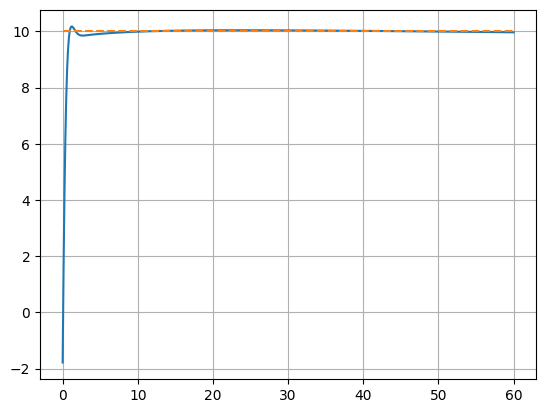

In [34]:
sp = 10

tData = np.linspace(0, 60, 1000)
uData = [sp for i in tData]
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)

plt.plot(time, response)
plt.plot(time, [sp for i in time], '--')
plt.grid()

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [35]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([ 341.12460052, -677.5248472 ,  336.39396825]), array([ 1.        , -1.78124216,  0.78588989]), 0.1)

In [36]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([-0.00011999,  0.000995  , -0.00066085]), array([ 1.        , -2.00309418,  1.00309923]), 0.1)

In [37]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([-0.04093027,  0.42071096, -0.93992808,  0.7824514 , -0.22230535]), array([ 0.95906973, -3.36362537,  4.41705683, -2.57852271,  0.5660202 ]), 0.1)

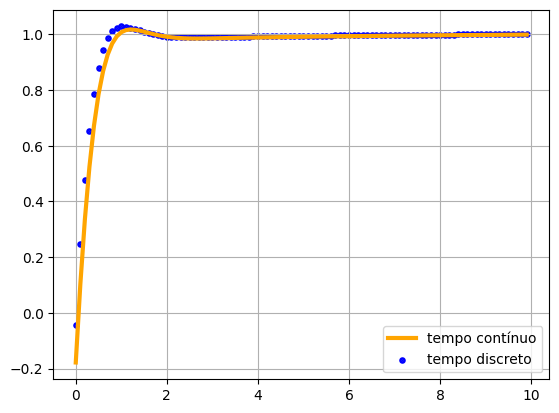

In [38]:
tLimits = np.arange(0, 10, T)

time, response = ctl.step_response(G_feedback, T=tLimits)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

time, response = ctl.step_response(G_z_feedback, T=tLimits)
plt.scatter(time, response, color='blue', linewidth=3, label='tempo discreto', s=3)

plt.legend()
plt.grid()
plt.show()

# COMPARANDO A RESPOSTA DO CONTROLADOR

- Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada

In [39]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

if type(num) == np.float64:
    num = np.array([num])

print(num)
print(den)

[-0.00011999  0.000995   -0.00066085]
[ 1.         -2.00309418  1.00309923]


- Printando a saída de forma a ser entendida por uma máquina de baixo nível

In [40]:
out = ''

for i in range(0, len(num)):
    out += f'{num[i]}*X_n{i} + '

for i in range(1, len(den)):
    out += f'+ {-1*den[i]}*Y_n{i}'

out = out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')
print(out + ';')

-0.0001199862755609793*X_n + 0.0009949950129772844*X_n1 -0.0006608482045864505*X_n2 + 2.00309417823423*Y_n1-1.0030992307925575*Y_n2;


- Resposta do controlador em feedback

In [41]:
Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = X_n4 = 0

def computeController(inputValue, setpoint):
    global Y_n1, Y_n2, Y_n3, Y_n4
    global X_n1, X_n2, X_n3, X_n4

    X_n =  setpoint - inputValue
    Y_n = eval(out)

    X_n4 = X_n3
    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n4 = Y_n3
    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

- Comparando os dados contínuo e digital de forma gráfica através de um step

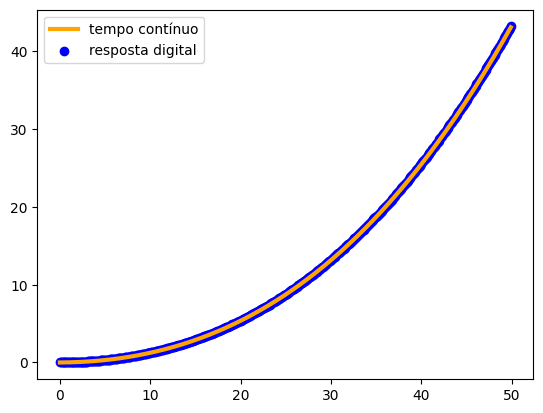

In [42]:
tLimits = np.arange(0, 50, T)

time, response = ctl.step_response(C, T=tLimits)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = Y_n4 = 0

response = [computeController(1, 2) for i in tLimits] # degrau (erro 1 é a entrada)
plt.scatter(time, response, color='blue', label='resposta digital')

plt.legend()
plt.show()

# TESTANDO A RESPOSTA
- Se o erro é positivo, o controlador atua aumentando a saída do sistema

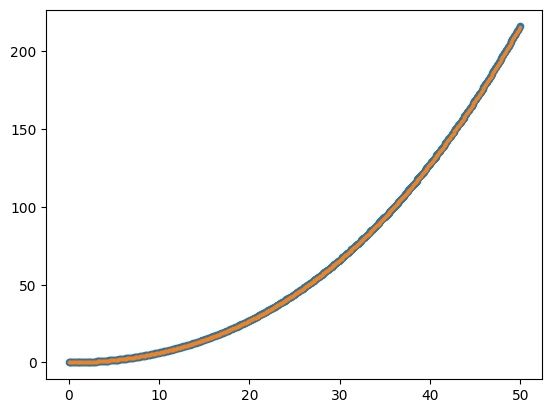

In [43]:
inputValue = 5
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = tLimits
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é negativo, o controlador atua diminuindo a saída do sistema

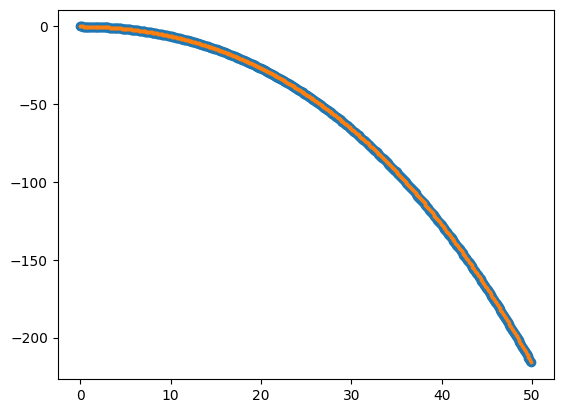

In [44]:
inputValue = 15
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = tLimits
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é zero, o não atua e mantém a saída fixa

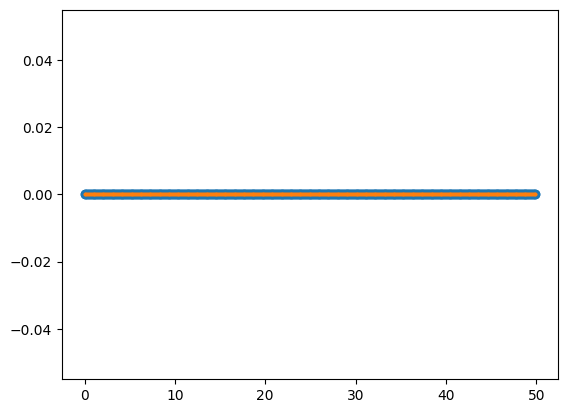

In [45]:
inputValue = 10
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = tLimits
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)